Careful! The origional Notebook includes errors. If you did not participate the lab session, you would not notice.

### Model-based anomaly detection.

In [64]:
import pandas as pd
# Generating radom data with each variable have 2 states and equal probabilities for each state
from sklearn.cross_validation import train_test_split
data = pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/NYC_taxi_sample.csv",index_col=0)
data=data-1
# train,test=train_test_split(data,random_state=999,test_size=0.2)
# train.head()
data.index=range(len(data))
data=data.iloc[:,:]
data.columns=list(data.columns)[:-1]+["passs"]
data.head()

,manhattan,tip,dist,speed,passs
0,0,0,0,0,0
1,0,2,4,5,0
2,0,0,5,3,1
3,1,1,1,1,0
4,0,3,0,0,0


Step 1: Learn structure. 

In [65]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('dist', 'speed'), ('dist', 'manhattan'), ('manhattan', 'tip'), ('manhattan', 'passs'), ('speed', 'manhattan'), ('passs', 'tip')]


In [67]:
# Defining the model
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

model = BayesianModel(best_model.edges())

# Learing CPDs using Maximum Likelihood Estimators
model.fit(data, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print model.get_independencies()

CPD of dist:
+---------+-----------+
| dist(0) | 0.312629  |
+---------+-----------+
| dist(1) | 0.227059  |
+---------+-----------+
| dist(2) | 0.130418  |
+---------+-----------+
| dist(3) | 0.106774  |
+---------+-----------+
| dist(4) | 0.0827547 |
+---------+-----------+
| dist(5) | 0.140364  |
+---------+-----------+
CPD of manhattan:
+--------------+----------------+----------------+----------------+----------------+----------+----------+---------------+----------------+----------+----------------+----------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+---------------+----------+----------------+----------------+----------------+----------+----------+----------------+----------------+---------------+----------------+----------+----------------+----------+----------------+----------------+----------------+
| dist         | dist(0)        | dist(0)        | dist(0)        | dist(0)        | d

### For example

In [68]:
a=data.iloc[1,:]
a

manhattan    0
tip          2
dist         4
speed        5
passs        0
Name: 1, dtype: int64

### Edges:

[('dist', 'speed'), ('dist', 'manhattan'), ('manhattan', 'tip'), ('manhattan', 'passs'), ('speed', 'manhattan'), ('passs', 'tip')]

In [58]:
from pgmpy.inference import VariableElimination
import numpy as np
infer = VariableElimination(model)
# ('dist'-->'speed'), 
print(infer.query(['speed'], evidence={'dist': 4}) ['speed'])

#('manhattan', -->'tip'), ('passs',---> 'tip')

print (infer.query(['tip'], evidence={'manhattan': 0, 'passs':0}) ['tip'])

#('manhattan', -->'pass'),  

print (infer.query(['passs'], evidence={'manhattan': 0}) ['passs'])

#('speed', -->'manhattan'), ('dist', 'manhattan'),
print (infer.query(['manhattan'], evidence={'speed': 5,'dist':4}) ['manhattan'])


+---------+--------------+
| speed   |   phi(speed) |
|---------+--------------|
| speed_0 |       0.0023 |
| speed_1 |       0.0726 |
| speed_2 |       0.2177 |
| speed_3 |       0.3333 |
| speed_4 |       0.2132 |
| speed_5 |       0.1610 |
+---------+--------------+
+-------+------------+
| tip   |   phi(tip) |
|-------+------------|
| tip_0 |     0.6052 |
| tip_1 |     0.0956 |
| tip_2 |     0.0878 |
| tip_3 |     0.1538 |
| tip_4 |     0.0353 |
| tip_5 |     0.0223 |
+-------+------------+
+---------+--------------+
| passs   |   phi(passs) |
|---------+--------------|
| passs_0 |       0.7020 |
| passs_1 |       0.1317 |
| passs_2 |       0.0554 |
| passs_3 |       0.1109 |
+---------+--------------+
+-------------+------------------+
| manhattan   |   phi(manhattan) |
|-------------+------------------|
| manhattan_0 |           0.9437 |
| manhattan_1 |           0.0563 |
+-------------+------------------+


In [69]:
print np.log((infer.query(['speed'], evidence={'tip': 2}) ['speed']).values[5])+np.log(
    (infer.query(['tip'], evidence={'manhattan': 0, 'passs':0}) ['tip']).values[2])+np.log(
    (infer.query(['passs'], evidence={'manhattan': 0}) ['passs']).values[0])+np.log(
    (infer.query(['manhattan'], evidence={'speed': 5,'dist':4}) ['manhattan']).values[0])

-5.74202877945


In [70]:
def logLiklihood(x,infer):
    a=x.manhattan
    b=x.tip
    c=x.dist
    d=x.speed
    e=x.passs
    return np.log((infer.query(['speed'], evidence={'tip': b}) ['speed']).values[d])+np.log(
    (infer.query(['tip'], evidence={'manhattan': a, 'passs':e}) ['tip']).values[b])+np.log(
    (infer.query(['passs'], evidence={'manhattan': a}) ['passs']).values[e])+np.log(
    (infer.query(['manhattan'], evidence={'speed': d,'dist':c}) ['manhattan']).values[a])

In [72]:
logLiklihood(data.iloc[1,:],infer)

-5.7420287794508429

In [73]:
exmp=data.iloc[:500,:].apply(lambda x: logLiklihood(x,infer),axis=1)

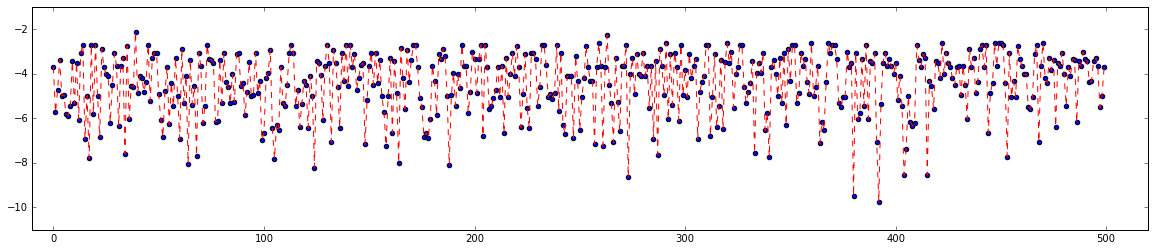

In [76]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.xlim(-10,520)
plt.plot(exmp,"r--")

In [77]:
exmp.sort_values()[:5]

392   -9.751562
380   -9.498807
273   -8.655281
404   -8.543923
415   -8.543923
dtype: float64

In [78]:
data.iloc[[392,380,273,404],:]

,manhattan,tip,dist,speed,passs
392,1,4,1,5,1
380,1,0,4,4,2
273,1,5,4,3,0
404,1,4,5,3,0


### Cluster-based anomaly detection

2) Cluster-based anomaly detection.  
a) Cluster with Gaussian Mixture. [logliklihood + tiny clusters]


b) Cluster with k-means, then compute each record's distance to the nearest cluster center.  The farthest-away records are considered most anomalous. 

Gaussian Mixture

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:100]
y=iris.target[:100]

In [82]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=5,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

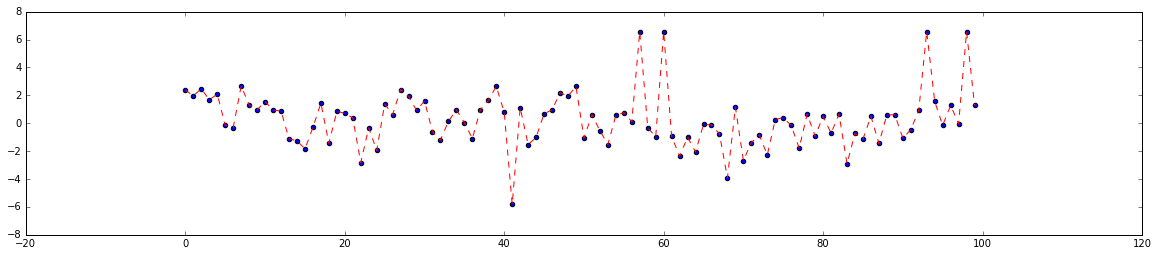

In [83]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()

In [84]:
pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5]

,0
41,-5.819147
68,-3.924819
83,-2.904986
22,-2.821749
70,-2.676683


Cluster with k-means, then compute each record's distance to the nearest cluster center

In [90]:
from sklearn.cluster import KMeans
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)
res=pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,3.696274,0.146942,2.850295
1,3.722713,0.438169,2.773389
2,3.896663,0.412301,2.947884
3,3.766571,0.518837,2.786429
4,3.746914,0.197970,2.900003


In [91]:
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
41,3.992124,1.239351,2.934993,1,1.239351
15,3.650624,1.213092,3.089771,1,1.213092
14,3.822522,1.020192,3.191659,1,1.020192
98,2.085697,1.985848,0.992900,2,0.992900
33,3.762177,0.928220,3.111540,1,0.928220


## Practice Question

The data we will use here are the hourly bicycle counts on Seattle's Fremont Bridge. These data come from an automated bicycle counter, installed in late 2012, which has inductive sensors under the sidewalks on either side of the bridge. The daily or hourly bicycle counts can be downloaded from http://data.seattle.gov/; here is the direct link to the hourly dataset. To download the data directly, you can uncomment the following curl command:

We are going to detect abnormal days...

In [92]:
import pandas as pd
data = pd.read_csv("https://serv.cusp.nyu.edu/~lw1474/ADS_Data/Prac_session/Bridge.csv", index_col='Date', parse_dates=True)
data=data.iloc[:-12000,:]
data.tail()

#We'll do some quick data cleaning: 
#we'll rename the columns to the shorter "West" and "East", 
#set any missing values to zero, and add a "Total" column:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')

In [93]:
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


C:\Users\lingjing\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app


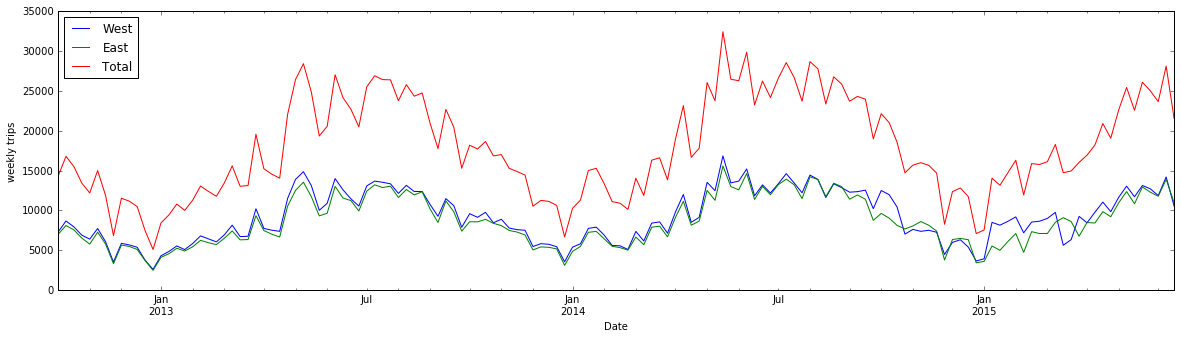

In [94]:
%matplotlib inline
data.resample('W', how='sum').plot(figsize=(20,5))
plt.ylabel('weekly trips')

In [95]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
days=pivoted.index
pivoted.head()

East                                      ... West                 \
             0  1  2    3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3.0  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3.0  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2.0  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2.0  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2.0  2   3   8   12   26   36 ...  126  122  132  118   

                                     
             18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [96]:
X = pivoted.values
X.shape

(990L, 48L)

## Use the methods above to detect which days are abnormal. 

If we cluster these dates by GM into two clusters, you will get Weekdays and Weekends. Now let's try to detect anomalys. 

1. Baysian Network.

2. Clustering. (Gaussian Mixture)

3. Clustering. (KMeans)

## Q1.

### Step1. pick hours: [0,11,15,18,21] and get the ratio instead.

In [102]:
XX=X[:,[0,11,15,18,21]]
XX=XX/XX.sum(1).reshape(-1,1)
XX.shape

(990L, 5L)

### Step2. Use pd.cut() to categorize the 5D feature space into 3 categories: 0,1,2 

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

In [103]:
import numpy as np
# convert to categorical
x=XX
xx=[]
for i in range(5):
    a=pd.cut(np.asarray(x)[:,i],3,labels=[0,1,2])
    xx.append(a)
x3=np.asarray(xx).T
x3.shape

(990L, 5L)

In [104]:
data1=pd.concat((pd.DataFrame(days),pd.DataFrame(x3)),axis=1)
data1.columns=["date","T1","T2","T3","T4","T5"]
data1.head()

,date,T1,T2,T3,T4,T5
0,2012-10-03,0,0,0,2,0
1,2012-10-04,0,0,0,2,0
2,2012-10-05,0,0,0,1,0
3,2012-10-06,0,0,1,0,0
4,2012-10-07,0,1,1,0,1


In [105]:
x3

array([[0, 0, 0, 2, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0],
       ..., 
       [0, 0, 0, 2, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 2, 0]], dtype=int64)

In [109]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
data=data1.iloc[:,1:]
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())
model = BayesianModel(best_model.edges())

# Learing CPDs using Maximum Likelihood Estimators
model.fit(data, estimator=MaximumLikelihoodEstimator)

[('T4', 'T5'), ('T4', 'T2'), ('T4', 'T1'), ('T3', 'T4')]


In [110]:
infer = VariableElimination(model)

In [120]:
def logLiklihood(x,infer):
    a=x.T1
    b=x.T2
    c=x.T3
    d=x.T4
    e=x.T5
    return np.log((infer.query(['T1'], evidence={'T4': d}) ['T1']).values[a])+np.log(
    (infer.query(['T2'], evidence={'T4': d}) ['T2']).values[b])+np.log(
    (infer.query(['T3']) ['T3']).values[c])+np.log(
        (infer.query(['T4'], evidence={'T3': c}) ['T4']).values[d])+np.log(
        (infer.query(['T5'], evidence={'T4': d}) ['T5']).values[e])

In [122]:
logLiklihood(data1.iloc[0,1:],infer)

-0.63062400775197591

In [124]:
exmp=data.iloc[:,:].apply(lambda x: logLiklihood(x,infer),axis=1)

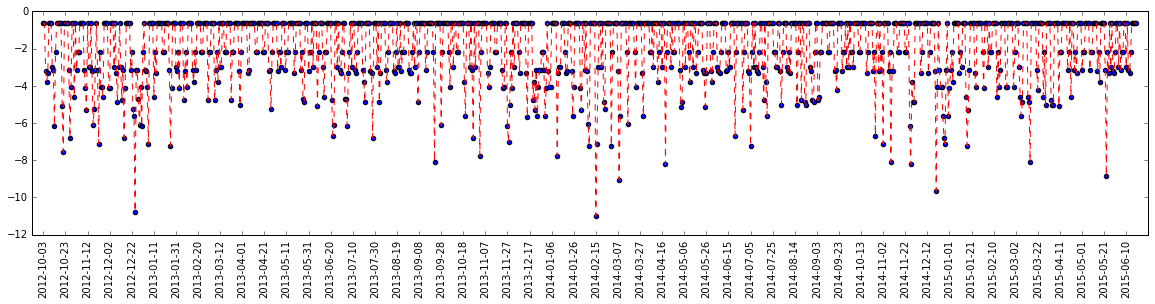

In [125]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.plot(exmp,"r--")
plt.xlim(-10,1000)
plt.xticks(range(len(exmp))[::20],days[:1000][::20],rotation=90)
plt.show()

### Q2. Gaussian Mixture.

In [128]:
X = pivoted.values
X=X/X.sum(1).reshape(-1,1)
data2=pd.concat((pd.DataFrame(days),pd.DataFrame(X)),axis=1)
data2.columns=["date"]+list(data2.columns)[1:]
data2.head()

,date,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,2012-10-03,0.002556,0.001704,0.000284,0.000852,0.000284,0.002840,0.014201,0.026981,0.041465,...,0.021869,0.020449,0.037773,0.054530,0.034649,0.016757,0.008236,0.007100,0.006816,0.001420
1,2012-10-04,0.003165,0.000000,0.001727,0.000863,0.000288,0.003165,0.014676,0.025612,0.038561,...,0.018129,0.021007,0.032806,0.044317,0.039424,0.016403,0.007770,0.008921,0.007194,0.003165
2,2012-10-05,0.002224,0.001271,0.000953,0.000635,0.000635,0.002224,0.011753,0.032084,0.037802,...,0.020013,0.025413,0.038119,0.045743,0.033990,0.013342,0.008577,0.003494,0.003177,0.005083
3,2012-10-06,0.003490,0.002493,0.000997,0.000997,0.000499,0.000997,0.007478,0.007976,0.023430,...,0.044367,0.057328,0.053340,0.053340,0.020439,0.019940,0.012463,0.008973,0.006979,0.007478
4,2012-10-07,0.002334,0.002334,0.000467,0.000934,0.000934,0.001401,0.003735,0.005602,0.012138,...,0.058824,0.056956,0.061625,0.055089,0.031746,0.012138,0.008870,0.005602,0.004202,0.002334


In [130]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=5,random_state=999)
GM.fit(data2.iloc[:,1:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

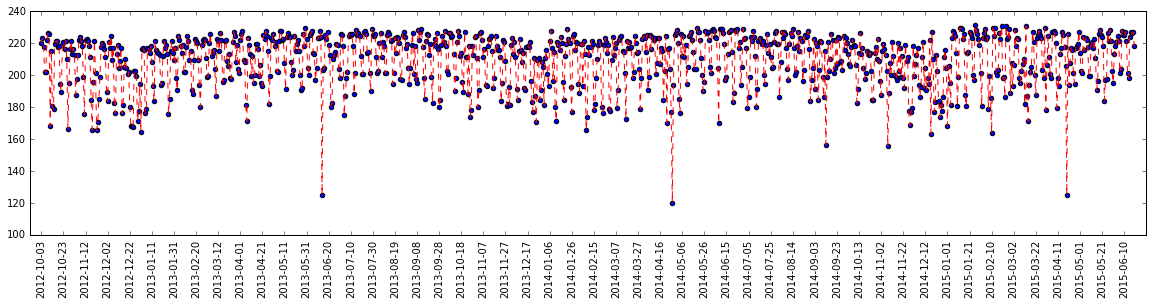

In [131]:
X=data2.iloc[:,1:]
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.xlim(-10,1000)
plt.xticks(range(len(exmp))[::20],days[::20],rotation=90)
plt.plot(GM.score_samples(X),"r--")
plt.show()

### Q3. KMeans

In [132]:
X = pivoted.values
X=X/X.sum(1).reshape(-1,1)
data2=pd.concat((pd.DataFrame(days),pd.DataFrame(X)),axis=1)
data2.columns=["date"]+list(data2.columns)[1:]
data2.head()

,date,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,2012-10-03,0.002556,0.001704,0.000284,0.000852,0.000284,0.002840,0.014201,0.026981,0.041465,...,0.021869,0.020449,0.037773,0.054530,0.034649,0.016757,0.008236,0.007100,0.006816,0.001420
1,2012-10-04,0.003165,0.000000,0.001727,0.000863,0.000288,0.003165,0.014676,0.025612,0.038561,...,0.018129,0.021007,0.032806,0.044317,0.039424,0.016403,0.007770,0.008921,0.007194,0.003165
2,2012-10-05,0.002224,0.001271,0.000953,0.000635,0.000635,0.002224,0.011753,0.032084,0.037802,...,0.020013,0.025413,0.038119,0.045743,0.033990,0.013342,0.008577,0.003494,0.003177,0.005083
3,2012-10-06,0.003490,0.002493,0.000997,0.000997,0.000499,0.000997,0.007478,0.007976,0.023430,...,0.044367,0.057328,0.053340,0.053340,0.020439,0.019940,0.012463,0.008973,0.006979,0.007478
4,2012-10-07,0.002334,0.002334,0.000467,0.000934,0.000934,0.001401,0.003735,0.005602,0.012138,...,0.058824,0.056956,0.061625,0.055089,0.031746,0.012138,0.008870,0.005602,0.004202,0.002334


In [154]:
from sklearn.cluster import KMeans

for i in range(2,10):    
    n=i
    KM=KMeans(n_clusters=n,random_state=999)
    X = pivoted.values
    X=X/X.sum(1).reshape(-1,1)
    KM.fit(X)
    res=pd.DataFrame(KM.transform(X))
    res=pd.concat((pd.DataFrame(days),res.min(1)),axis=1)
    res.columns=["date","score"]
    print res.sort_values("score",ascending=False)[:5]in

           date     score
805  2014-12-17  0.164696
909  2015-03-31  0.159481
803  2014-12-15  0.159275
799  2014-12-11  0.159183
894  2015-03-16  0.153351
           date     score
50   2012-11-22  0.120683
521  2014-03-08  0.120146
448  2013-12-25  0.116379
563  2014-04-19  0.111001
766  2014-11-08  0.109521
           date     score
50   2012-11-22  0.120683
521  2014-03-08  0.120146
448  2013-12-25  0.116379
563  2014-04-19  0.111001
766  2014-11-08  0.109521
           date     score
50   2012-11-22  0.110715
766  2014-11-08  0.110645
613  2014-06-08  0.105361
448  2013-12-25  0.105086
83   2012-12-25  0.104056
           date     score
766  2014-11-08  0.110667
50   2012-11-22  0.108101
448  2013-12-25  0.105595
613  2014-06-08  0.104920
83   2012-12-25  0.104795
           date     score
766  2014-11-08  0.109268
83   2012-12-25  0.103030
613  2014-06-08  0.102468
254  2013-06-14  0.099663
186  2013-04-07  0.097027
           date     score
766  2014-11-08  0.109375
83   2012-12

### LOF

Local outlier factor (LOF).

Need 0.19dev version. 

Code: https://github.com/scikit-learn/scikit-learn/blob/7d1e430/sklearn/neighbors/lof.py

Install 0.19dev.

pip install git+git://github.com/scikit-learn/scikit-learn.git

Not suggested!!

Automatically created module for IPython interactive environment


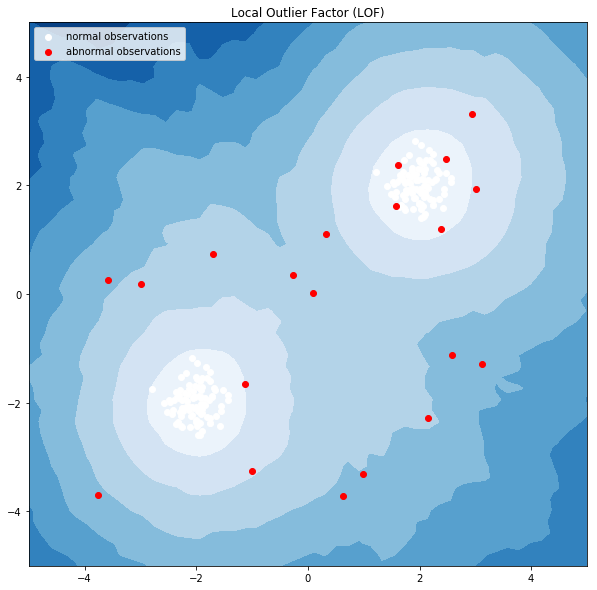

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)

np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))


plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

### One Class SVM and Isolation Forest

Automatically created module for IPython interactive environment


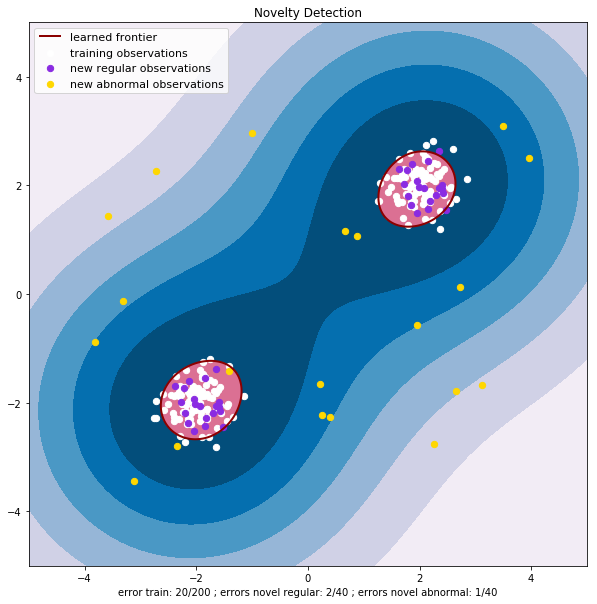

In [8]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

Automatically created module for IPython interactive environment


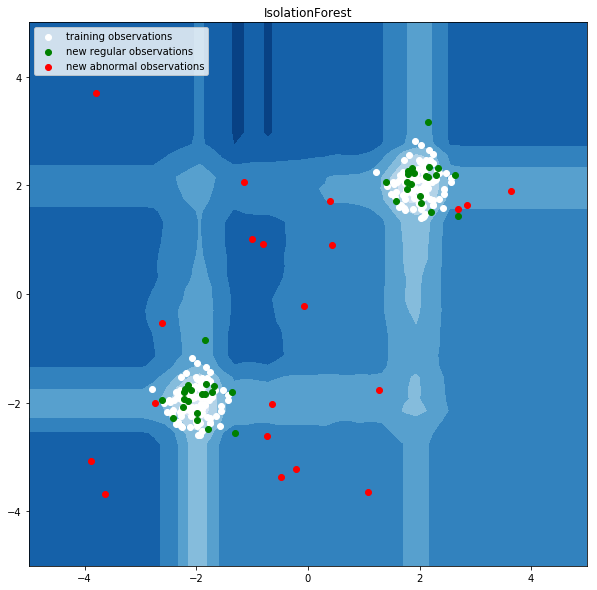

In [9]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

P.S. Sklearn makes a distinction between "novelty detection" with clean training data and "outlier detection" with training data possibly corrupted by a small proportion of anomalies.  This is _not_ standard usage-- anomaly, outlier, and novelty detection are generally used interchangeably in the literature, and it should be separately specified whether or not the training data is assumed to be clean.